# 🐶 End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

### Get our workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [1]:
# # Import TensorFlow into Notebook
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.1.0


In [2]:
# Import necessary tools
import matplotlib.pyplot as plt
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.1.0
TF Hub version: 0.8.0


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("./dog-breed-identification/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     e237f2c2da59abcb4d622106db8eef11  scottish_deerhound
freq                                   1                 126


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<AxesSubplot:>

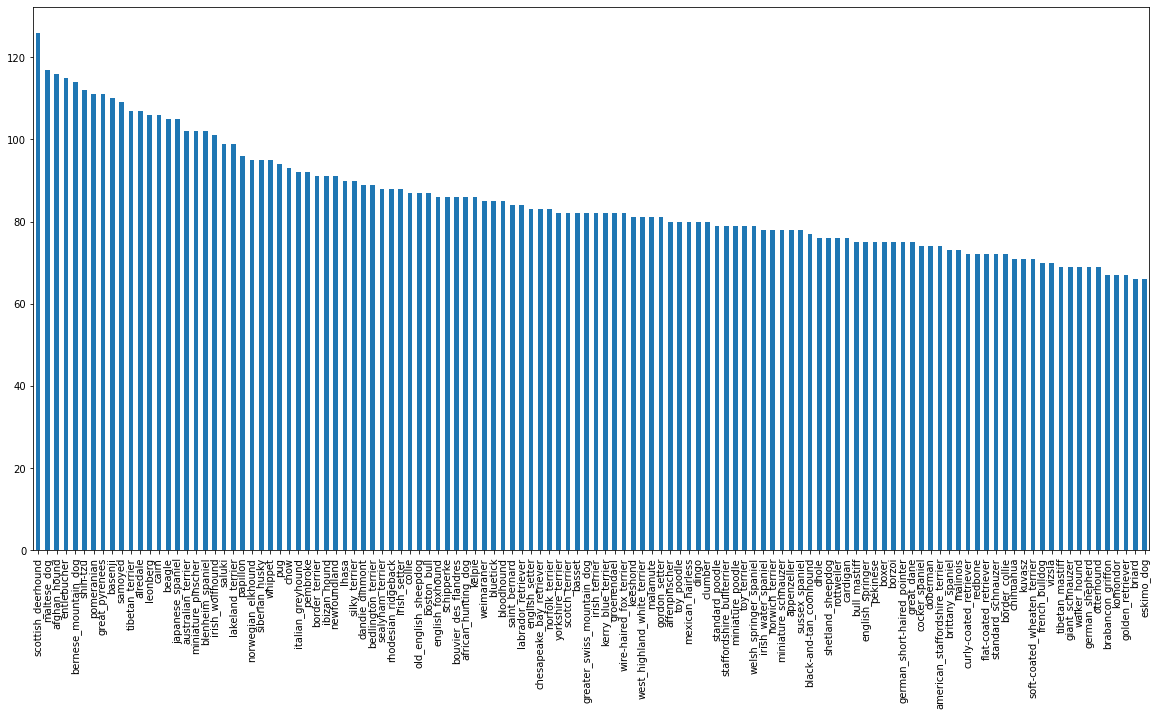

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [6]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

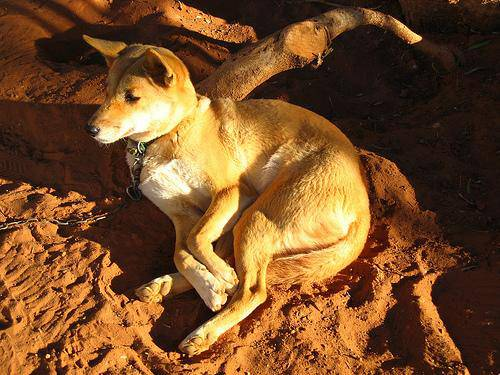

In [7]:
# Let's view an image
from IPython.display import Image
Image("./dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels 

Let's get a list of all of our image file pathnames.

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# Create pathnames from image ID's
filenames = ["dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("dog-breed-identification/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


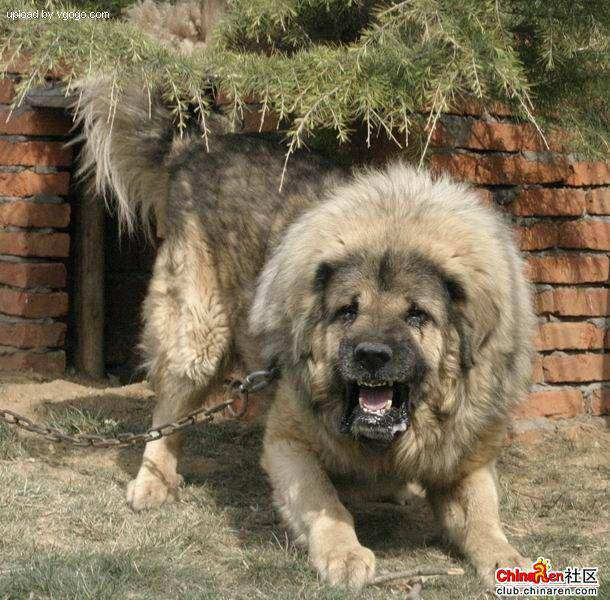

In [11]:
# One more check
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy() 
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# turn boolean_labels into numbers
for i in range(len(labels)):
    boolean_labels[i] = boolean_labels[i].astype(int)

In [22]:
# a quick check for the first label
boolean_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Creating our own validation set
Since Kaggle doesn't provide a validation set for this dataset, let's make our own.

In [23]:
# Setup X and y variables
X = filenames
y = boolean_labels

We're going to start off with around 1k images and increase as needed.

In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000

In [25]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [26]:
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

# Preprocessing images( turning data into tensors)
To preprocess our images into tensors, we're going to write a function which does a few things.
1. Take an image filepath as input.
2. Use TensorFlow to read a file and save it to a variable, `image`.
3. Normalise the image ( divide each pixel value by 255) .
4. Turn `image` into tensors.
5. Resize the `image` to be a shape of (224,224)

In [27]:
# convert image into NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[43])
image.shape

(500, 401, 3)

In [28]:
image

array([[[178, 165, 131],
        [179, 166, 132],
        [182, 167, 134],
        ...,
        [ 59,  45,  36],
        [ 53,  39,  30],
        [ 38,  30,  19]],

       [[176, 163, 129],
        [178, 165, 131],
        [180, 165, 132],
        ...,
        [ 61,  47,  38],
        [ 55,  41,  32],
        [ 40,  32,  21]],

       [[175, 162, 128],
        [176, 163, 129],
        [179, 164, 131],
        ...,
        [ 63,  49,  40],
        [ 56,  42,  33],
        [ 43,  35,  24]],

       ...,

       [[117, 112,  93],
        [124, 119, 100],
        [136, 129, 111],
        ...,
        [128, 100,  78],
        [145, 121,  97],
        [165, 138, 127]],

       [[125, 120, 101],
        [128, 123, 104],
        [136, 129, 111],
        ...,
        [142, 114,  92],
        [156, 132, 108],
        [170, 143, 132]],

       [[134, 129, 110],
        [135, 130, 111],
        [139, 132, 114],
        ...,
        [149, 121,  99],
        [160, 136, 112],
        [165, 138, 127]]

In [29]:
# Lets see the Tensor version of this image
tf.constant(image)

<tf.Tensor: shape=(500, 401, 3), dtype=uint8, numpy=
array([[[178, 165, 131],
        [179, 166, 132],
        [182, 167, 134],
        ...,
        [ 59,  45,  36],
        [ 53,  39,  30],
        [ 38,  30,  19]],

       [[176, 163, 129],
        [178, 165, 131],
        [180, 165, 132],
        ...,
        [ 61,  47,  38],
        [ 55,  41,  32],
        [ 40,  32,  21]],

       [[175, 162, 128],
        [176, 163, 129],
        [179, 164, 131],
        ...,
        [ 63,  49,  40],
        [ 56,  42,  33],
        [ 43,  35,  24]],

       ...,

       [[117, 112,  93],
        [124, 119, 100],
        [136, 129, 111],
        ...,
        [128, 100,  78],
        [145, 121,  97],
        [165, 138, 127]],

       [[125, 120, 101],
        [128, 123, 104],
        [136, 129, 111],
        ...,
        [142, 114,  92],
        [156, 132, 108],
        [170, 143, 132]],

       [[134, 129, 110],
        [135, 130, 111],
        [139, 132, 114],
        ...,
        [149, 121,  9

Now that we've seen what an image looks like in Tensor form, let's write a function to process them.

In [30]:
# Define image size
IMG_SIZE = 224 

# Create a function for preprocesing images.
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image path and turns it into a tensor
    """
    # Read image
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical tensor with 3 color channels
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel value from 0 to 255 to 0 to 1 values (normalise)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value(224,224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    
    return image

### Turning our data into batches
Why turn our data into batches?

*Let's say you're trying to train 10000+ images in one go, they all might not fit into memory.*
*That's why we do about 32 images at a time (conventional batch size).*

In order to use TensorFlow effectively, we need our data in the form of tuples which look like this:
`(image, label)`

In [31]:
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

In [32]:
# Demo of the above function
get_image_label(X[42],tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuple of tensors `(image, label)`, let's make a function to turn all of our data `X` and `y` into batches.

In [33]:
# Define a batch size, 32 is a good start.
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches out of image(X) and label(y) pairs.
    Shuffles the data if it's training data and doesn't if its validation data.
    Also accepts test data as input.
    """
    if test_data:
        print("Creating test data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    
    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
    
    print("Done!!")    
    return data_batch

In [34]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Done!!
Creating validation data batches...
Done!!


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)))

## Visualising data batches.
Our data is now in batches. Let's visualise it.

In [36]:
import matplotlib.pyplot as plt

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [37]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int32)>

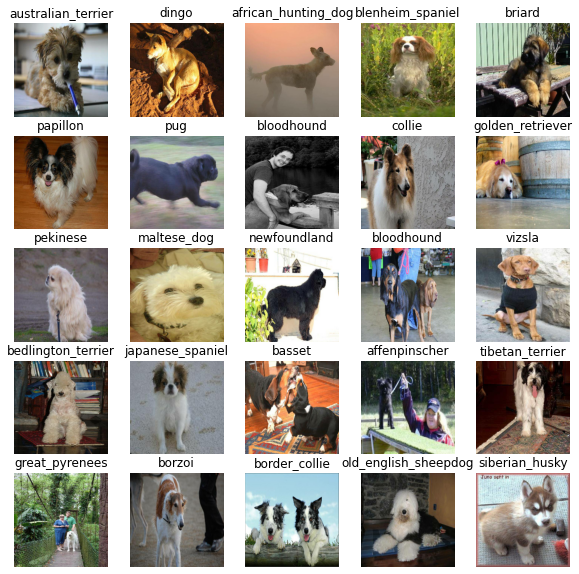

In [38]:
## Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

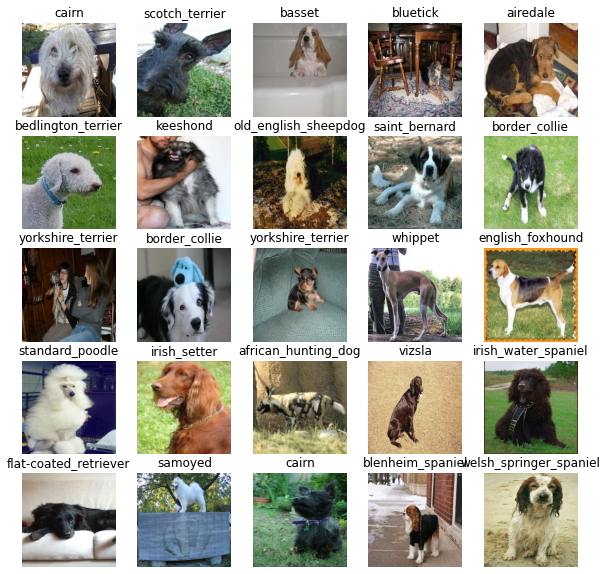

In [40]:
## Now let's visualize the data in a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [42]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [43]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [44]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [45]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [61]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [62]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [63]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [64]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU not available :(


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [65]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [66]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 59s 2s/step - loss: 4.4172 - accuracy: 0.1088 - val_loss: 3.1767 - val_accuracy: 0.3050
Epoch 2/100
25/25 [==============================] - 49s 2s/step - loss: 1.5588 - accuracy: 0.6850 - val_loss: 2.0729 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 50s 2s/step - loss: 0.5436 - accuracy: 0.9325 - val_loss: 1.5975 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 44s 2s/step - loss: 0.2426 - accuracy: 0.9900 - val_loss: 1.4390 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 32s 1s/step - loss: 0.1419 - accuracy: 0.9987 - val_loss: 1.3702 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 31s 1s/step - loss: 0.0987 - accuracy: 0.9987 - val_loss: 1.3345 - val_accuracy: 0.6500
Epoch 7/100
25/25 [=

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [71]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 10420), started 0:06:13 ago. (Use '!kill 10420' to kill it.)

## Making and evaluating predictions using a trained model 

In [72]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int32)>

In [73]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 9s 1s/step


array([[6.9938350e-04, 1.8131643e-04, 1.0292190e-03, ..., 5.5621917e-05,
        1.4899548e-05, 1.3021913e-03],
       [1.1799241e-03, 1.8325895e-03, 7.9873033e-02, ..., 1.1499599e-03,
        8.9918240e-04, 4.7199752e-05],
       [2.5736232e-05, 4.6630750e-05, 1.0628931e-05, ..., 4.1161067e-05,
        8.9289633e-06, 4.0021114e-05],
       ...,
       [4.2477623e-06, 2.2374927e-05, 1.6687883e-04, ..., 8.5435395e-06,
        2.0607067e-05, 2.7833647e-05],
       [3.5728898e-03, 1.5080613e-04, 1.3088351e-04, ..., 7.2634532e-05,
        8.5056723e-05, 1.1180651e-02],
       [1.5532275e-04, 2.4968876e-05, 8.8804396e-04, ..., 4.6564112e-03,
        8.5648592e-04, 3.7590798e-04]], dtype=float32)

In [74]:
predictions[0]

array([6.99383498e-04, 1.81316427e-04, 1.02921901e-03, 5.82164357e-05,
       1.94242166e-04, 2.92606146e-05, 3.15950029e-02, 3.44508589e-04,
       2.99871957e-04, 1.47213577e-04, 5.18390480e-05, 1.29031017e-04,
       1.08173932e-03, 7.94293650e-04, 1.37612078e-04, 2.94912490e-04,
       1.45816943e-04, 1.59767225e-01, 1.09745990e-04, 5.69019248e-05,
       3.76495125e-04, 1.24324579e-04, 2.18081077e-05, 1.14131765e-03,
       2.28121498e-05, 7.76866000e-05, 2.83173919e-01, 1.45164522e-04,
       2.09246250e-03, 8.78110295e-04, 3.35350342e-04, 7.64884928e-04,
       3.65332380e-04, 6.53285897e-05, 1.77527661e-04, 6.64117113e-02,
       4.37235612e-05, 4.45386133e-04, 2.14193878e-05, 4.03262675e-05,
       1.35397166e-03, 6.70789595e-05, 1.02798353e-04, 3.63475228e-05,
       1.65701131e-05, 8.83721295e-05, 5.59605796e-05, 2.28173085e-04,
       2.08714817e-04, 1.24510931e-04, 3.71265705e-05, 4.04807470e-05,
       4.43382560e-05, 2.62790691e-05, 2.72860161e-05, 2.11969764e-05,
      

In [75]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.12751397e-04 2.99792100e-05 1.08605200e-04 2.48891920e-05
 2.50420719e-03 5.89709198e-05 1.85742334e-04 3.26016708e-03
 3.18176188e-02 3.93456258e-02 2.43648137e-05 5.86391470e-05
 2.91248027e-04 2.99870316e-02 1.35763956e-03 2.90969736e-03
 8.80504103e-06 1.98825204e-04 1.96662178e-04 8.63441091e-04
 3.23779313e-05 2.55044154e-03 3.29369614e-05 8.41124565e-05
 1.98224671e-02 2.52833939e-04 8.35929823e-05 1.61829143e-04
 2.22372735e-04 1.60290714e-04 1.48902967e-04 8.42427398e-05
 2.28015633e-05 8.86846174e-05 1.99193673e-05 4.17943593e-05
 1.04273917e-04 2.33541432e-04 1.66009704e-04 1.44066840e-01
 3.28335474e-04 1.39335452e-05 5.84586337e-03 2.24801715e-05
 7.14434718e-04 5.73250400e-05 4.81767696e-04 2.10134382e-03
 1.53076413e-04 1.94054650e-04 3.70184483e-04 1.43494690e-04
 4.06839594e-04 1.70958345e-03 4.80815288e-05 3.90004891e-04
 2.02062016e-04 1.53722431e-04 3.68860492e-04 1.06150394e-04
 2.68641190e-04 2.03815545e-03 4.09810564e-05 1.00525802e-04
 3.20112478e-04 4.362300

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [76]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [77]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int32)>

In [78]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [80]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

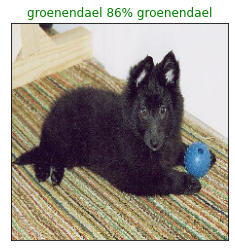

In [81]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [82]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

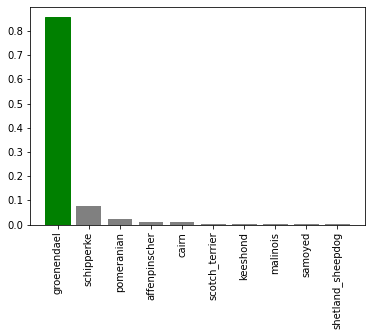

In [83]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=77)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

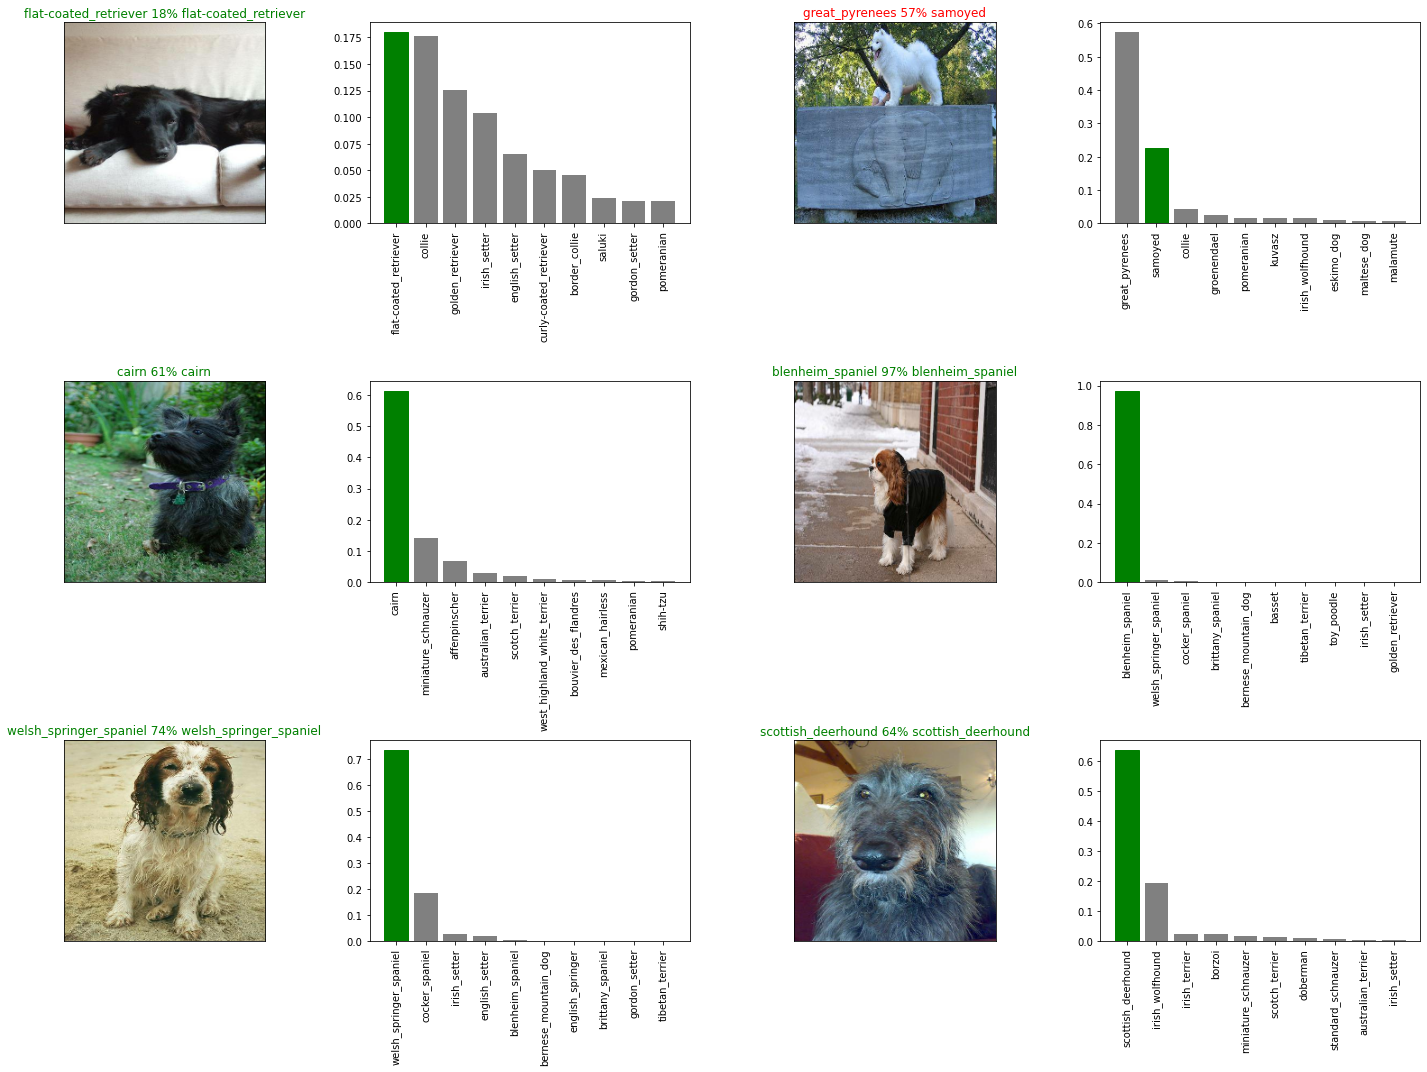

In [84]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [144]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [145]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [146]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

ValueError: Invalid format string